In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [8]:
# Load Dataset
df = pd.read_csv('train_data.csv')
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df.set_index('TIMESTAMP', inplace=True)

In [9]:
# Calculate Log Returns if not already present
df['LOG_RETURNS_HHI'] = np.log(df['LAST_PRICE_HHI'] / df['LAST_PRICE_HHI'].shift(1))
df['LOG_RETURNS_HSI'] = np.log(df['LAST_PRICE_HSI'] / df['LAST_PRICE_HSI'].shift(1))
df.dropna(inplace=True)

# Scale LOG_RETURNS_HHI
scaler = StandardScaler()
df['LOG_RETURNS_HHI_scaled'] = scaler.fit_transform(df[['LOG_RETURNS_HHI']])

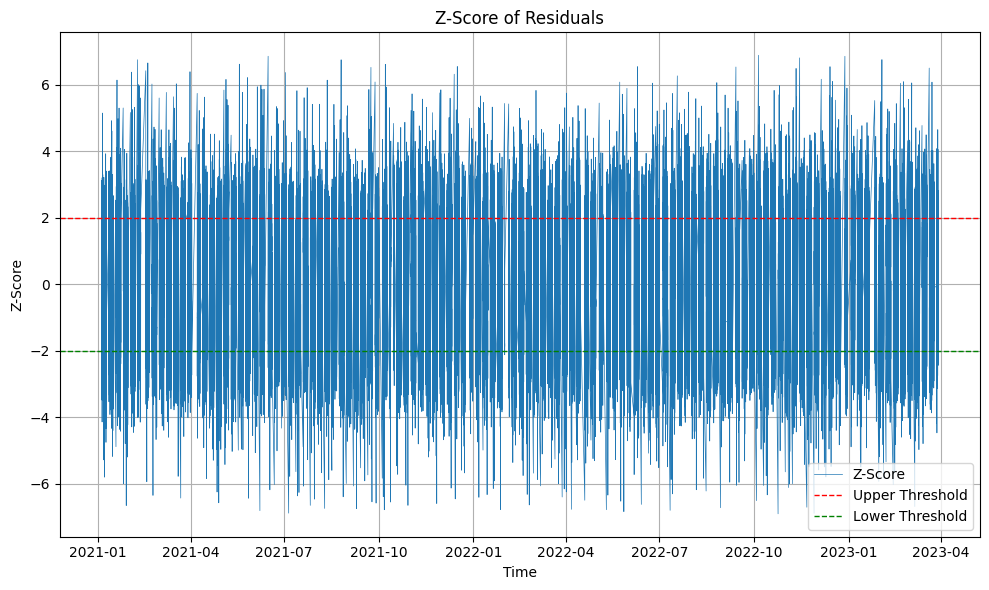

In [12]:
# Train Linear Regression Model
X = df[['LOG_RETURNS_HHI_scaled']]
y = df['LOG_RETURNS_HSI']
model = LinearRegression()
model.fit(X, y)
df['predicted_HSI'] = model.predict(X)

# Calculate Residuals
df['residual'] = df['LAST_PRICE_HSI'] - df['predicted_HSI']

# Calculate Z-Score of Residuals
rolling_window = 50  # Adjust rolling window size
df['residual_mean'] = df['residual'].rolling(window=rolling_window).mean()
df['residual_std'] = df['residual'].rolling(window=rolling_window).std()
df['z_score'] = (df['residual'] - df['residual_mean']) / df['residual_std']

# Plot Z-Scores
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['z_score'], label='Z-Score', linewidth=0.5)
plt.axhline(2, color='red', linestyle='--', linewidth=1, label='Upper Threshold')
plt.axhline(-2, color='green', linestyle='--', linewidth=1, label='Lower Threshold')
plt.title('Z-Score of Residuals')
plt.xlabel('Time')
plt.ylabel('Z-Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

signal
 0    445491
 1     34231
-1     32319
Name: count, dtype: int64


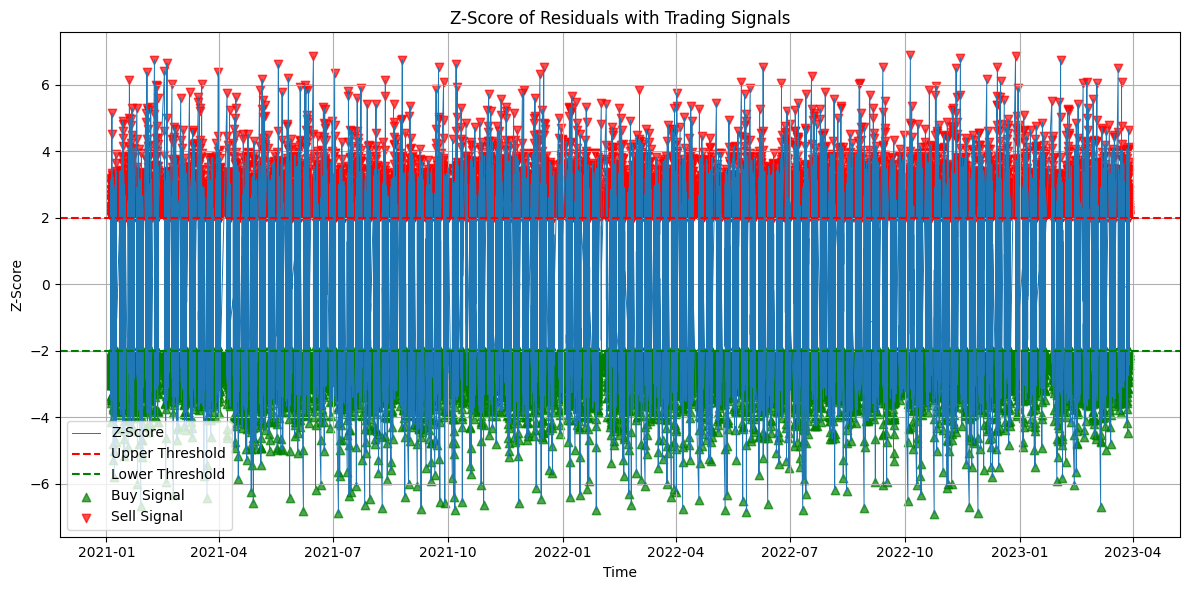

In [13]:
# Generate Trading Signals Based on Z-Score
def generate_signals(row, upper_threshold=2, lower_threshold=-2):
    if row['z_score'] < lower_threshold:
        return 1  # Buy Signal
    elif row['z_score'] > upper_threshold:
        return -1  # Sell Signal
    else:
        return 0  # Hold Signal

# Apply Signal Generation
df['signal'] = df.apply(generate_signals, axis=1)

# Display Signal Counts (Optional)
print(df['signal'].value_counts())

# Plot Z-Score with Signals
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['z_score'], label='Z-Score', linewidth=0.7)
plt.axhline(2, color='red', linestyle='--', label='Upper Threshold')
plt.axhline(-2, color='green', linestyle='--', label='Lower Threshold')

# Highlight Buy and Sell Signals
plt.scatter(df.index[df['signal'] == 1], df['z_score'][df['signal'] == 1], 
            color='green', label='Buy Signal', marker='^', alpha=0.7)
plt.scatter(df.index[df['signal'] == -1], df['z_score'][df['signal'] == -1], 
            color='red', label='Sell Signal', marker='v', alpha=0.7)

plt.title('Z-Score of Residuals with Trading Signals')
plt.xlabel('Time')
plt.ylabel('Z-Score')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


Results Summary:
final_portfolio_value: 100000.0
total_pnl: 0.0
max_drawdown: 0
sharpe_ratio: -0.7906531711786906
total_transaction_costs: 0
cash_deltas: List of 512041 values


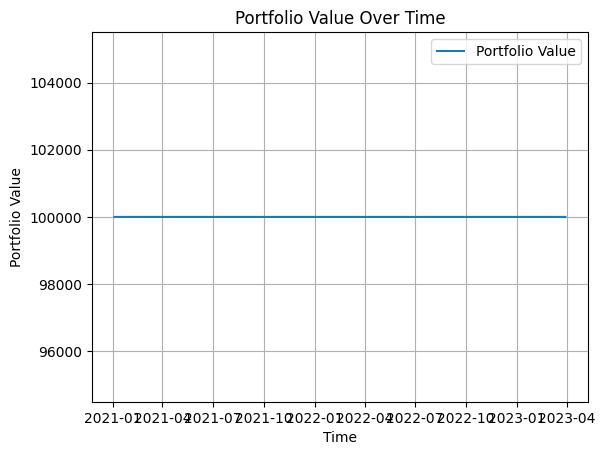

In [11]:

# Generate Trading Signals Based on Z-Score
def generate_signals(row, upper_threshold=2, lower_threshold=-2):
    if row['z_score'] < lower_threshold:
        return 1  # Buy
    elif row['z_score'] > upper_threshold:
        return -1  # Sell
    else:
        return 0  # Hold

df['signal'] = df.apply(generate_signals, axis=1)

# Portfolio Initialization
initial_cash = 100000  # Starting cash in USD
cash = initial_cash
hsi_position = 0
portfolio_value = []
transaction_costs = 0
cash_deltas = []
portfolio_peak = initial_cash
max_drawdown = 0

# Transaction Costs
transaction_cost_rate = 0.001  # 0.1% per trade

# Simulate Trading
for idx, row in df.iterrows():
    price = row['LAST_PRICE_HSI']
    signal = row['signal']
    available_liquidity = min(row['LAST_BID_VOLUME_HSI'], row['LAST_ASK_VOLUME_HSI'])

    # Skip if no liquidity
    if available_liquidity <= 0:
        portfolio_value.append(cash + hsi_position * price)
        continue

    # Adjust trade volume to use 10% of cash
    max_affordable_volume = (cash * 0.1) // price  # 10% of cash
    trade_volume = min(max_affordable_volume, available_liquidity)

    trade_cash_delta = 0  # Track cash delta for this trade

    if trade_volume > 0:
        transaction_cost = trade_volume * price * transaction_cost_rate
        trade_value = trade_volume * price + transaction_cost

        if signal == 1 and cash >= trade_value:  # Buy
            hsi_position += trade_volume
            cash -= trade_value
            trade_cash_delta = -trade_value
        elif signal == -1 and hsi_position >= trade_volume:  # Sell
            hsi_position -= trade_volume
            cash += trade_volume * price - transaction_cost
            trade_cash_delta = trade_volume * price - transaction_cost

        # Accumulate transaction costs
        transaction_costs += transaction_cost

    # Update Portfolio Value
    holdings_value = hsi_position * price
    current_portfolio_value = cash + holdings_value
    portfolio_value.append(current_portfolio_value)

    # Track Cash Delta
    cash_deltas.append(trade_cash_delta)

    # Check Drawdown
    portfolio_peak = max(portfolio_peak, current_portfolio_value)
    drawdown = (portfolio_peak - current_portfolio_value) / portfolio_peak
    max_drawdown = max(max_drawdown, drawdown)

# Add Portfolio Value to DataFrame
df['portfolio_value'] = portfolio_value

# Performance Metrics
final_portfolio_value = portfolio_value[-1]
pnl = final_portfolio_value - initial_cash
sharpe_ratio = (np.mean(df['LOG_RETURNS_HSI']) / np.std(df['LOG_RETURNS_HSI'])) * np.sqrt(len(df))

# Results Dictionary
results = {
    'final_portfolio_value': final_portfolio_value,
    'total_pnl': pnl,
    'max_drawdown': max_drawdown,
    'sharpe_ratio': sharpe_ratio,
    'total_transaction_costs': transaction_costs,
    'cash_deltas': cash_deltas,  # All cash delta changes
}

# Print Results
print("Results Summary:")
for key, value in results.items():
    if isinstance(value, list):
        print(f"{key}: List of {len(value)} values")
    else:
        print(f"{key}: {value}")

# Plot Portfolio Value
import matplotlib.pyplot as plt
plt.plot(df.index, df['portfolio_value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

